In [199]:
import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

In [200]:
train = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
df    = pd.concat([train,test],axis=0, sort=False)
df.head()

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,salary_next_year
0,0,nelsoge01,1986,1,CHA,AL,6,6,54,1,...,3.0,3.0,0.0,488.0,26.0,52,NaN,NaN,NaN,365000.0
1,1,moyerja01,1997,1,SEA,AL,17,5,30,30,...,3.0,7.0,0.0,787.0,0.0,82,NaN,NaN,NaN,2000000.0
2,2,thompbr01,2008,1,SLN,NL,6,3,26,6,...,2.0,3.0,0.0,273.0,10.0,38,NaN,NaN,NaN,650000.0
3,3,powerte01,1986,1,CIN,NL,10,6,56,10,...,5.0,1.0,1.0,537.0,30.0,59,NaN,NaN,NaN,500000.0
4,4,osunaan01,2003,1,NYA,AL,2,5,48,0,...,3.0,2.0,0.0,232.0,16.0,22,NaN,NaN,NaN,750000.0


In [201]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df)

,Missing Ratio
GIDP,100.000000
SF,100.000000
SH,100.000000
BAOpp,39.050453
salary_next_year,15.000676
BK,0.013526
HBP,0.013526
WP,0.013526
IBB,0.013526


In [202]:
# 去除大量遺失數據
df = df.drop(['GIDP','SF','SH'],axis=1)
df.shape

(7393, 29)

In [203]:
mask = (df['BK'].isnull() | df['HBP'].isnull() | df['WP'].isnull() | df['IBB'].isnull())
print("極少量遺失數據數量=",mask.sum())
df.iloc[mask.values]
print("推測因沒上場幾次，所以應該都為零")
df.iloc[mask.values] = df.iloc[mask.values].fillna(0)
na_check(df)

極少量遺失數據數量= 1
推測因沒上場幾次，所以應該都為零


,Missing Ratio
BAOpp,39.050453
salary_next_year,14.987150


In [204]:
# fill BAOpp
from xgboost import XGBRegressor
from sklearn import metrics  
from sklearn.model_selection import train_test_split

In [205]:
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)

data_x = df.iloc[:,6:28]
data_y = data_x['BAOpp']
data_x.drop('BAOpp', axis=1)

train_x = data_x[data_y.notna()]
test_x  = data_x[data_y.isna()]
train_y = data_y[data_y.notna()]

train_X, test_X, train_Y, test_Y = train_test_split(train_x, train_y, test_size=0.6)

model.fit(train_X, train_Y)
predict_train_y= model.predict(train_X)
score_train = metrics.r2_score(train_Y, predict_train_y)
print('train score=', score_train)
predict_test_y= model.predict(test_X)
score_test = metrics.r2_score(test_Y, predict_test_y)
print('test score=', score_test)


C:\Users\ASUS\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train score= 0.9999814708430935
test score= 0.9991610481801778


In [206]:
df['BAOpp'][df['BAOpp'].isna().values]=model.predict(test_x)
df['BAOpp'][df['BAOpp']<=0]=0

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [207]:
na_check(df)

,Missing Ratio
salary_next_year,14.98715


# -----------------------
# 先分析object數據


In [208]:
df.columns[df.dtypes == 'object']

Index(['playerID', 'teamID', 'lgID'], dtype='object')

In [209]:
#df['playerName'] = df['playerID'].apply(lambda x: x[:-2])
#df['playerIDint']   = df['playerID'].apply(lambda x: int(x[-2:]))
#print(len(df['playerIDint'].unique()),",   ",df['playerIDint'].unique())
#print(len(df['playerName'].unique()),",   ",len(df['playerID'].unique()),",   ",len(df))
#print("\n-----\nplayerName_top10\n-----\n", df['playerName'].value_counts().head(10))
print("\n-----\nplayerID_top10\n-----\n", df['playerID'].value_counts().head(10))
print("\n-----\nplayerID_top10\n-----\n", df['playerID'].value_counts().tail(10))


-----
playerID_top10
-----
 moyerja01    24
glavito02    21
maddugr01    20
clemero02    20
johnsra05    20
rogerke01    19
francjo01    19
wellsda01    19
smoltjo01    19
gordoto01    19
Name: playerID, dtype: int64

-----
playerID_top10
-----
 kellesh01    2
rzepcma01    2
bannibr01    2
lannajo01    2
smithmi03    2
lucasga01    2
bairdo01     2
johnsda04    2
saundto01    2
mccurje01    2
Name: playerID, dtype: int64


In [210]:
mask = (df['playerID']=='moyerja01').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year
1498,1498,moyerja01,1986,1,CHN,NL,7,4,16,16,...,0.310000,5.05,1.0,3.0,3.0,3.0,395.0,0.0,52,70000.0
1402,1402,moyerja01,1987,1,CHN,NL,12,15,35,33,...,0.270000,5.10,9.0,11.0,5.0,2.0,899.0,1.0,127,142500.0
5856,5856,moyerja01,1988,1,CHN,NL,9,15,34,30,...,0.270000,3.48,7.0,4.0,4.0,0.0,855.0,1.0,84,205000.0
6221,6221,moyerja01,1989,1,TEX,AL,4,9,15,15,...,0.280000,4.86,0.0,1.0,2.0,0.0,337.0,0.0,51,340000.0
2001,2001,moyerja01,1990,1,TEX,AL,2,6,33,10,...,0.290000,4.66,4.0,1.0,4.0,0.0,447.0,6.0,59,200000.0
1675,1675,moyerja01,1991,1,SLN,NL,0,5,8,7,...,0.310000,5.74,0.0,2.0,1.0,1.0,142.0,1.0,21,200000.0
1045,1045,moyerja01,1993,1,BAL,AL,12,9,25,25,...,0.260000,3.43,2.0,1.0,6.0,1.0,630.0,0.0,63,725000.0
4367,4367,moyerja01,1994,1,BAL,AL,5,7,23,23,...,0.260000,4.77,3.0,1.0,2.0,0.0,631.0,0.0,81,1100000.0
4784,4784,moyerja01,1995,1,BAL,AL,8,6,27,18,...,0.250000,5.21,0.0,0.0,3.0,0.0,483.0,3.0,70,825000.0
544,6828,moyerja01,1996,1,BOS,AL,7,1,23,10,...,0.270000,4.50,2.0,2.0,1.0,1.0,405.0,1.0,50,NaN


In [211]:
mask = (df['playerID']=='glavito02').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year
1436,1436,glavito02,1987,1,ATL,NL,2,4,9,9,...,0.270000,5.54,4.0,1.0,3.0,1.0,238.0,0.0,34,65000.0
4982,4982,glavito02,1988,1,ATL,NL,7,17,34,34,...,0.270000,4.56,7.0,2.0,8.0,2.0,844.0,0.0,111,117500.0
662,662,glavito02,1989,1,ATL,NL,14,8,29,29,...,0.240000,3.68,3.0,2.0,2.0,0.0,766.0,0.0,88,285000.0
5084,5084,glavito02,1990,1,ATL,NL,10,12,33,33,...,0.280000,4.28,10.0,8.0,1.0,1.0,929.0,0.0,111,697500.0
4140,4140,glavito02,1991,1,ATL,NL,20,11,34,34,...,0.220000,2.55,6.0,10.0,2.0,2.0,989.0,0.0,83,2975000.0
731,7015,glavito02,1992,1,ATL,NL,20,8,33,33,...,0.230000,2.76,7.0,5.0,2.0,0.0,919.0,0.0,81,NaN
635,635,glavito02,1993,1,ATL,NL,22,6,36,36,...,0.250000,3.20,7.0,4.0,2.0,0.0,1014.0,0.0,91,4750000.0
4584,4584,glavito02,1994,1,ATL,NL,13,9,25,25,...,0.250000,3.97,10.0,8.0,1.0,1.0,731.0,0.0,76,4750000.0
3278,3278,glavito02,1995,1,ATL,NL,16,7,29,29,...,0.240000,3.08,0.0,3.0,5.0,0.0,822.0,0.0,76,5350000.0
962,962,glavito02,1996,1,ATL,NL,15,10,36,36,...,0.220000,2.98,7.0,4.0,0.0,0.0,994.0,0.0,91,5050000.0


In [212]:
mask = (df['playerID']=='latosma01').values
df.iloc[mask,:].sort_values(by='yearID')

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,salary_next_year
774,774,latosma01,2010,1,SDN,NL,14,10,31,31,...,0.000179,2.92,3.0,5.0,2.0,1.0,748.0,0.0,63,460700.0
2522,2522,latosma01,2011,1,SDN,NL,9,14,31,31,...,0.000000,3.47,3.0,5.0,1.0,0.0,799.0,0.0,82,550000.0


In [213]:
NewColumns = ['years','firstsalary','firstyear', 'salary_the_year', 'totalyears']
for t in NewColumns: df[t] = np.nan

def year(dfx):
    global df
    N = len(dfx)
    for ix,i in  enumerate(dfx.sort_values(by='yearID')['id']):  #dfx.sort_values(by='yearID')['id']
        df['years'].iloc[i]       =  dfx['yearID'].iloc[ix]-dfx['yearID'].min()
        df['firstsalary'].iloc[i] =  dfx['salary_next_year'][dfx['yearID']==dfx['yearID'].min()].values[0]    
        df['firstyear'].iloc[i]   =  dfx['yearID'].min()
        df['totalyears'].iloc[i]  =  N
        if ix==0: 
            df['salary_the_year'].iloc[i] = dfx['salary_next_year'][dfx['yearID']==dfx['yearID'].min()].values[0]   
        else:
            df['salary_the_year'].iloc[i] = dfx.sort_values(by='yearID')['salary_next_year'].iloc[ix-1]
        
    return dfx['yearID']-dfx['yearID'].min()

df.groupby('playerID').apply(year)
df.head()

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,BK,BFP,GF,R,salary_next_year,years,firstsalary,firstyear,salary_the_year,totalyears
0,0,nelsoge01,1986,1,CHA,AL,6,6,54,1,...,0.0,488.0,26.0,52,365000.0,4.0,240000.0,1985.0,240000.0,7.0
1,1,moyerja01,1997,1,SEA,AL,17,5,30,30,...,0.0,787.0,0.0,82,2000000.0,15.0,70000.0,1986.0,NaN,24.0
2,2,thompbr01,2008,1,SLN,NL,6,3,26,6,...,0.0,273.0,10.0,38,650000.0,0.0,400000.0,2006.0,414000.0,3.0
3,3,powerte01,1986,1,CIN,NL,10,6,56,10,...,1.0,537.0,30.0,59,500000.0,5.0,500000.0,1985.0,500000.0,8.0
4,4,osunaan01,2003,1,NYA,AL,2,5,48,0,...,0.0,232.0,16.0,22,750000.0,9.0,NaN,1995.0,2400000.0,10.0


In [214]:
for y in sorted(df['firstyear'].unique()):
    mask = (df['firstyear']==df['yearID']) & (df['firstyear']==y)
    print(y,"  = ",mask.sum(), "  na= ", df[mask]['firstsalary'].isna().sum())

df['lgID'].value_counts()

1985.0   =  141   na=  21
1986.0   =  82   na=  12
1987.0   =  26   na=  3
1988.0   =  23   na=  5
1989.0   =  46   na=  10
1990.0   =  47   na=  7
1991.0   =  30   na=  4
1992.0   =  34   na=  4
1993.0   =  85   na=  13
1994.0   =  45   na=  6
1995.0   =  69   na=  13
1996.0   =  34   na=  3
1997.0   =  53   na=  12
1998.0   =  43   na=  2
1999.0   =  54   na=  6
2000.0   =  19   na=  3
2001.0   =  33   na=  9
2002.0   =  45   na=  6
2003.0   =  40   na=  4
2004.0   =  35   na=  2
2005.0   =  42   na=  5
2006.0   =  51   na=  8
2007.0   =  56   na=  5
2008.0   =  48   na=  8
2009.0   =  36   na=  3
2010.0   =  34   na=  5


NL    3822
AL    3571
Name: lgID, dtype: int64

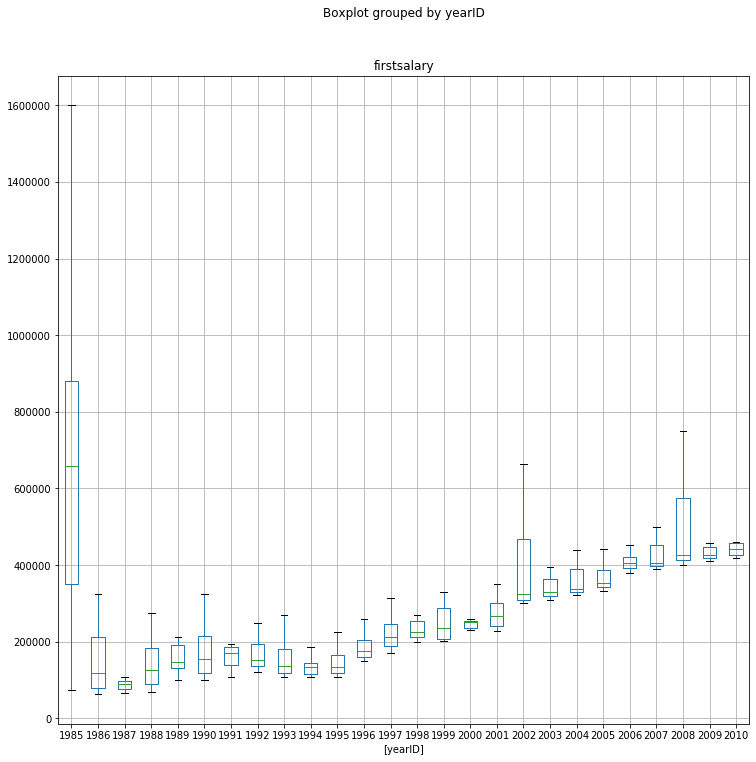

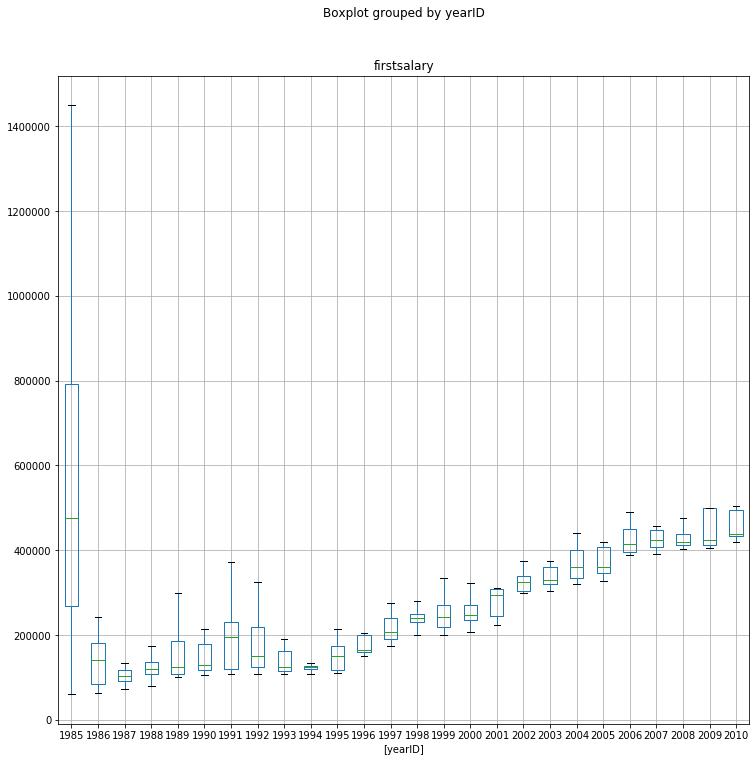

In [215]:
df[(df['firstyear']==df['yearID']) & (df['lgID']=='NL')].boxplot(column=['firstsalary'], by = ['yearID'], showfliers = False, figsize=(12,12))
df[(df['firstyear']==df['yearID']) & (df['lgID']=='AL')].boxplot(column=['firstsalary'], by = ['yearID'], showfliers = False, figsize=(12,12))

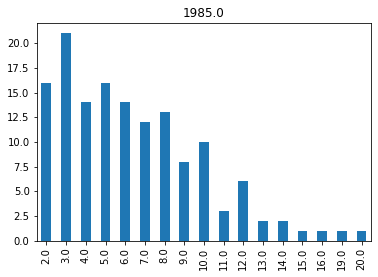

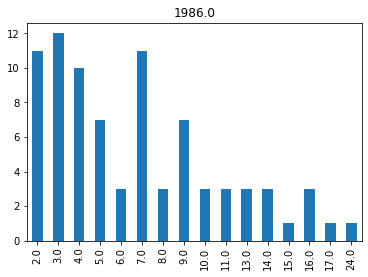

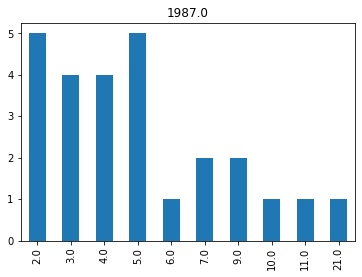

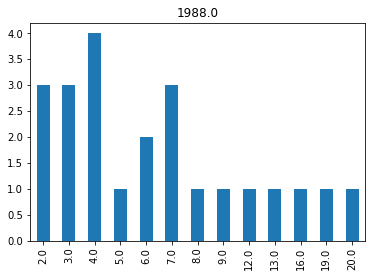

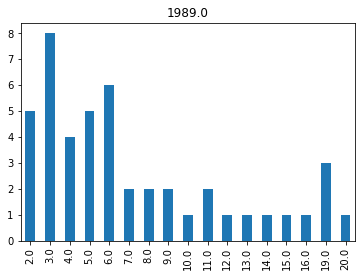

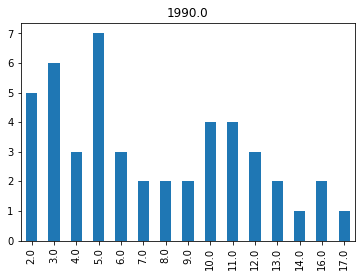

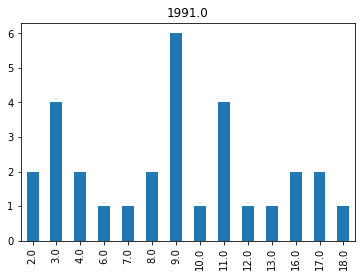

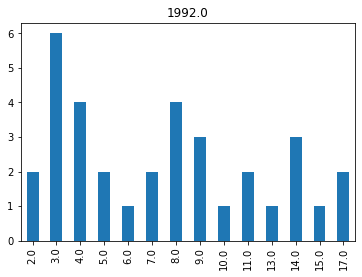

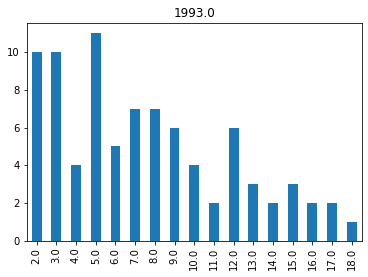

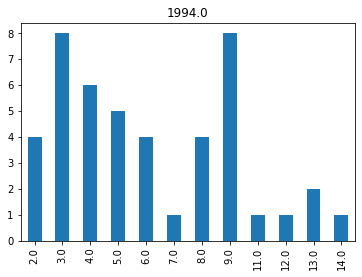

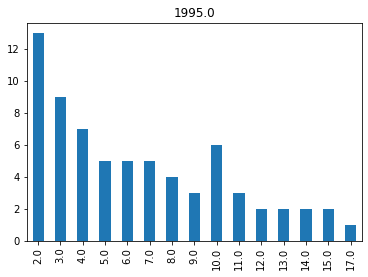

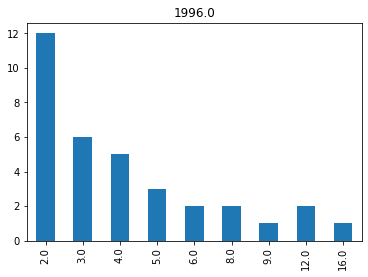

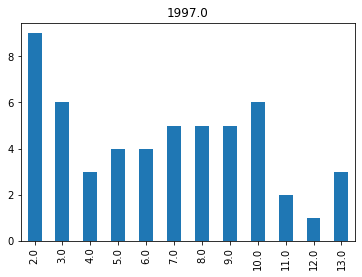

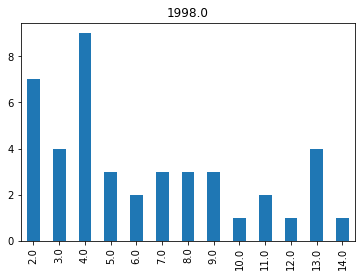

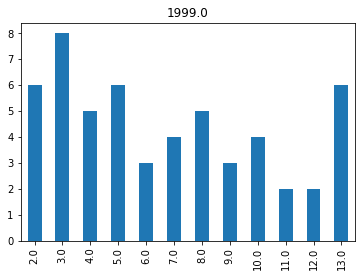

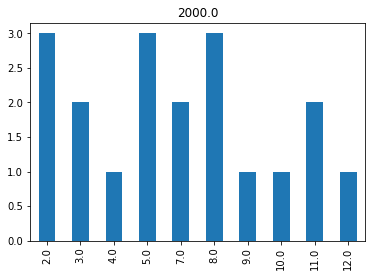

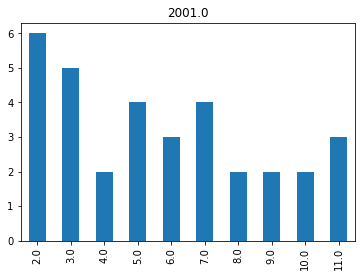

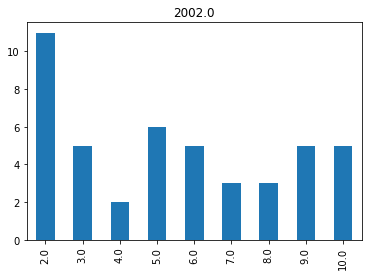

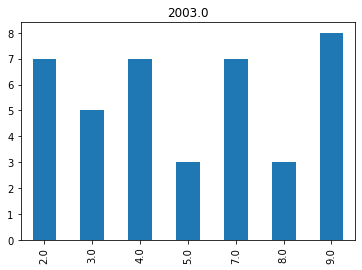

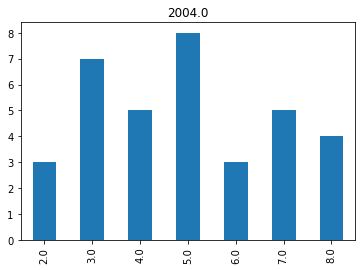

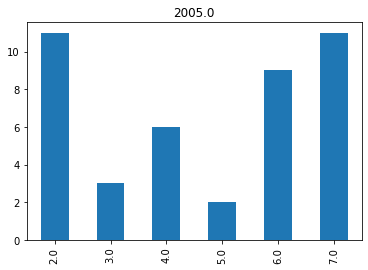

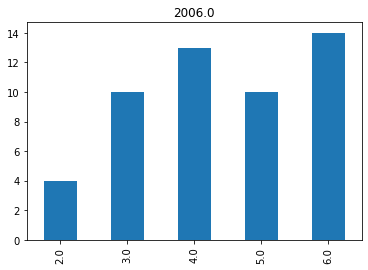

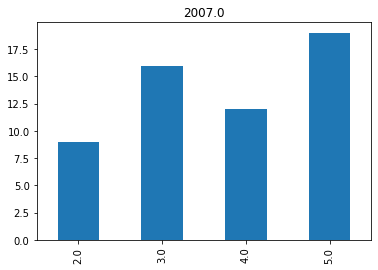

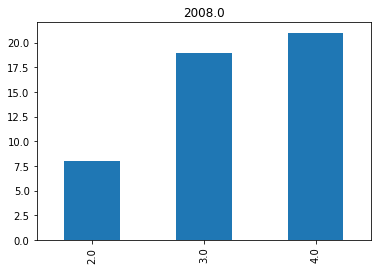

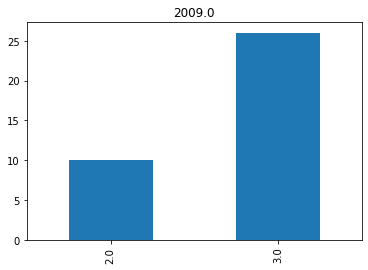

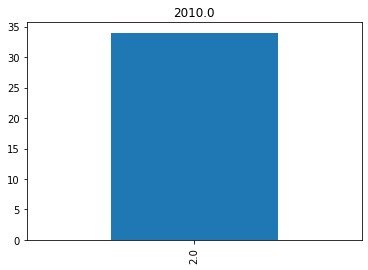

In [216]:
#每年開始 到結束的年限期
for y in sorted(df['firstyear'].unique()):
    mask = (df['firstyear']==y)
    #print(df[mask].groupby('playerID')['totalyears'].mean().value_counts().sort_index())
    df[mask].groupby('playerID')['totalyears'].mean().value_counts().sort_index().plot.bar()
    plt.title(str(y))
    plt.show()


# 計算起薪


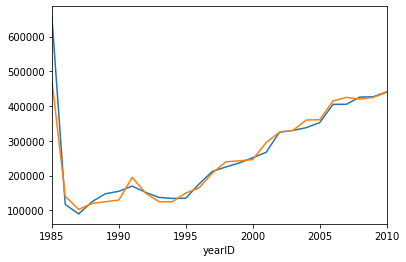

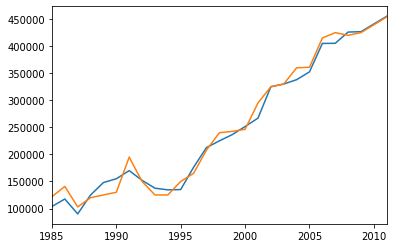

In [217]:
# 不同公司給隨時間給予的起薪中位數 (1985不準，推測資料不完整)
df[(df['firstyear']==df['yearID']) & (df['lgID']=='NL')].groupby('yearID')['firstsalary'].median().plot()
df[(df['firstyear']==df['yearID']) & (df['lgID']=='AL')].groupby('yearID')['firstsalary'].median().plot()
plt.show()

NewColumns = ['NL_startsalary_by_year','AL_startsalary_by_year']
for t in NewColumns: df[t] = df['yearID'].copy()
    
a = df[(df['firstyear']==df['yearID']) & (df['lgID']=='NL')].groupby('yearID')['firstsalary'].median()
a[a.index==1985] = (a[a.index==1986].values+a[a.index==1987].values)*0.5
a = a.append(pd.Series([a[a.index==2010].values[0]*2-a[a.index==2009].values[0]], index=[2011]))
df['NL_startsalary_by_year'] = df['NL_startsalary_by_year'].map(a.to_dict())

b = df[(df['firstyear']==df['yearID']) & (df['lgID']=='AL')].groupby('yearID')['firstsalary'].median()
b[b.index==1985] = (b[b.index==1986].values+b[b.index==1987].values)*0.5
b = b.append(pd.Series([b[b.index==2010].values[0]*2-b[b.index==2009].values[0]], index=[2011]))
df['AL_startsalary_by_year'] = df['AL_startsalary_by_year'].map(b.to_dict())

a.plot()
b.plot()
plt.show()

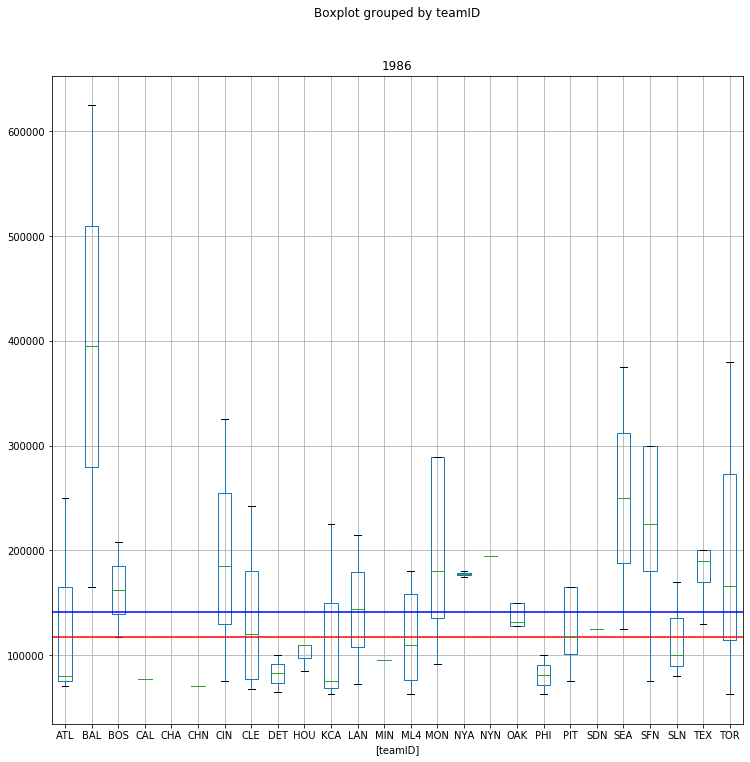

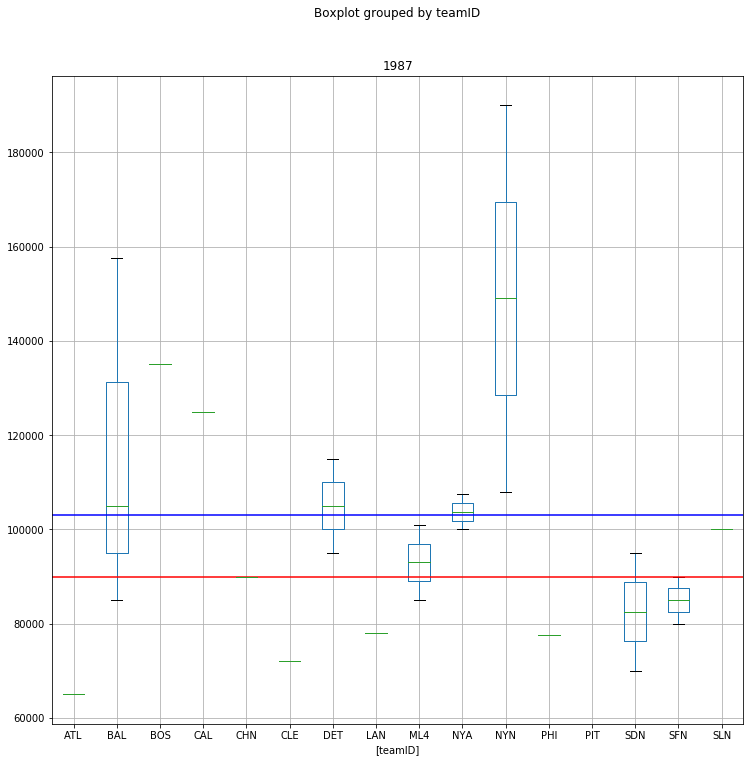

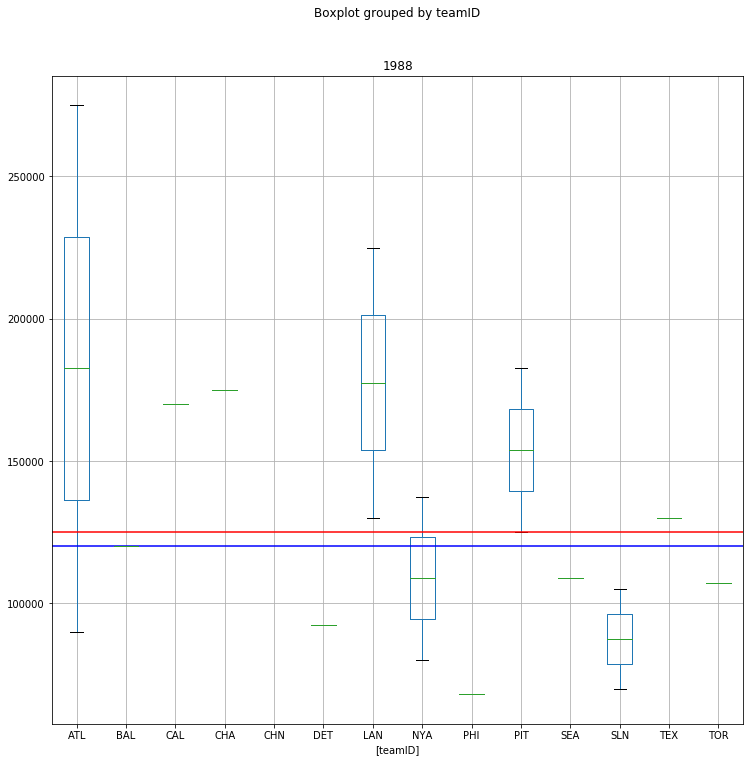

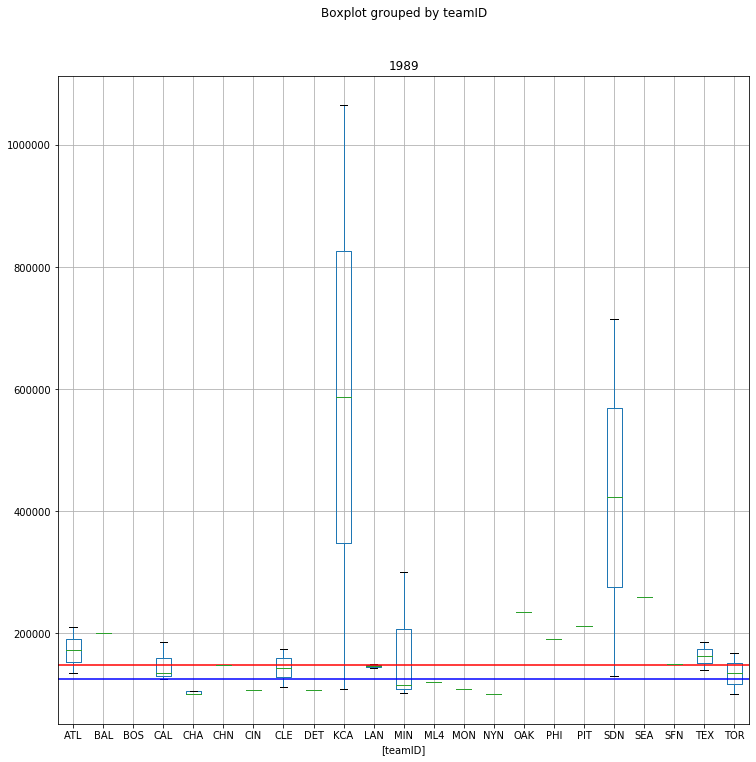

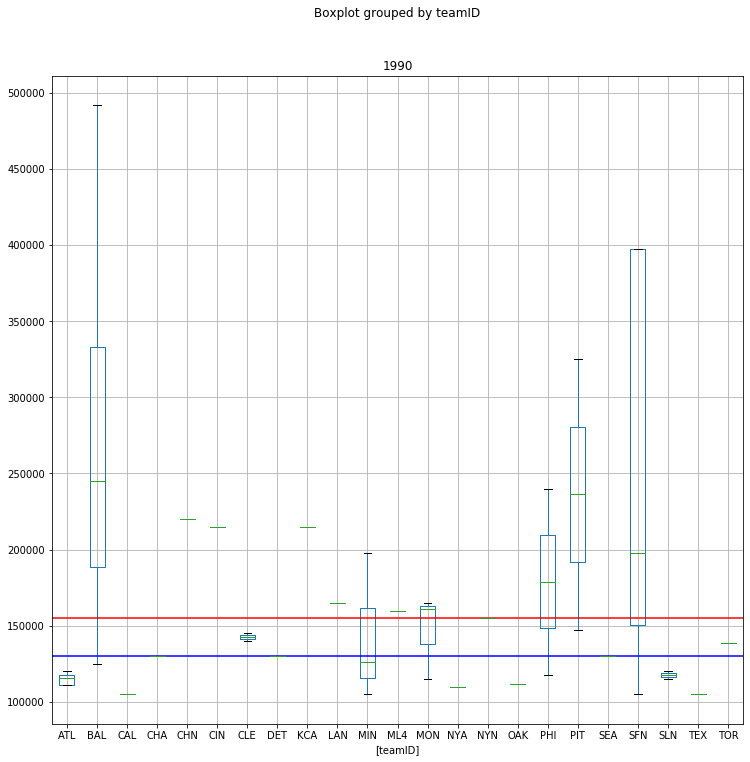

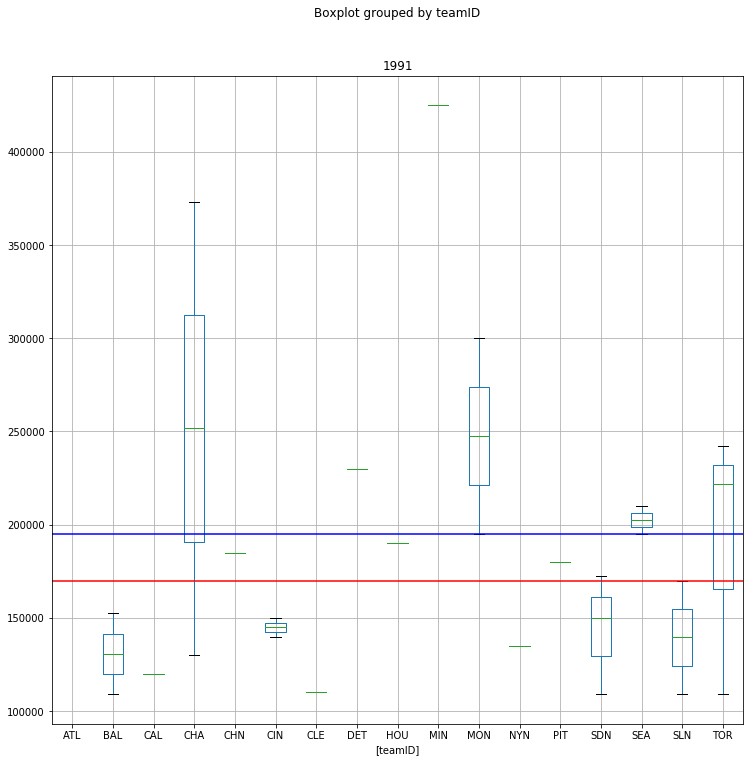

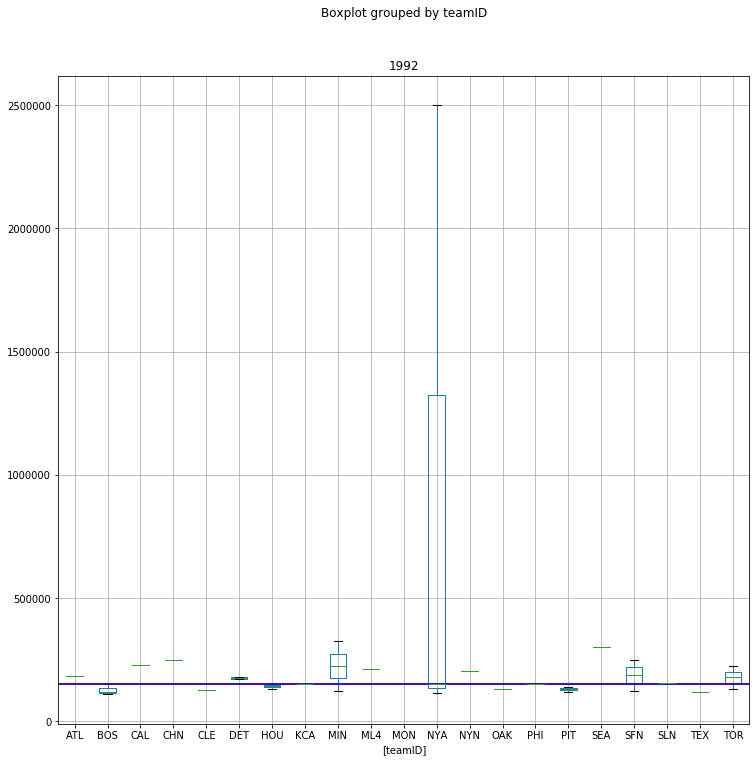

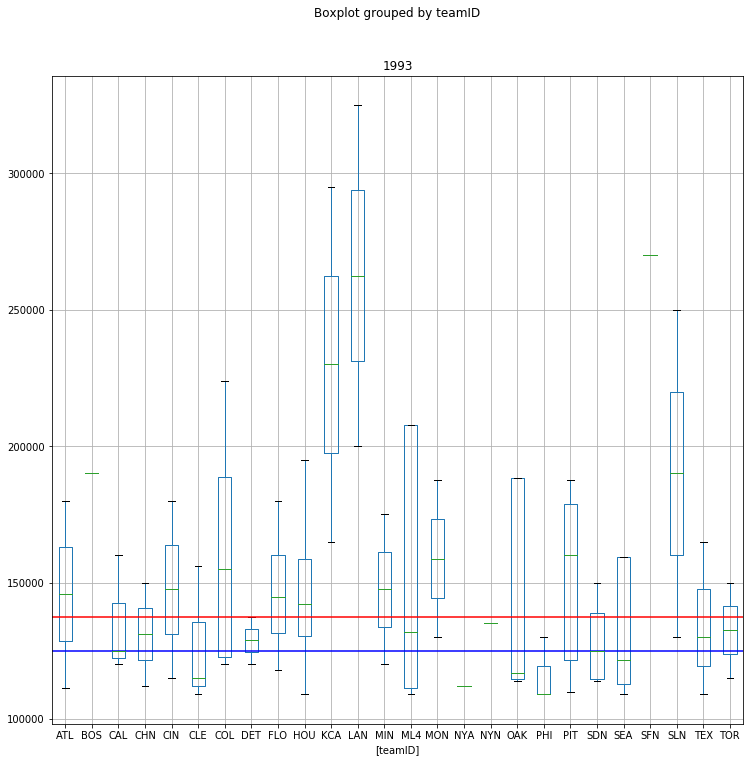

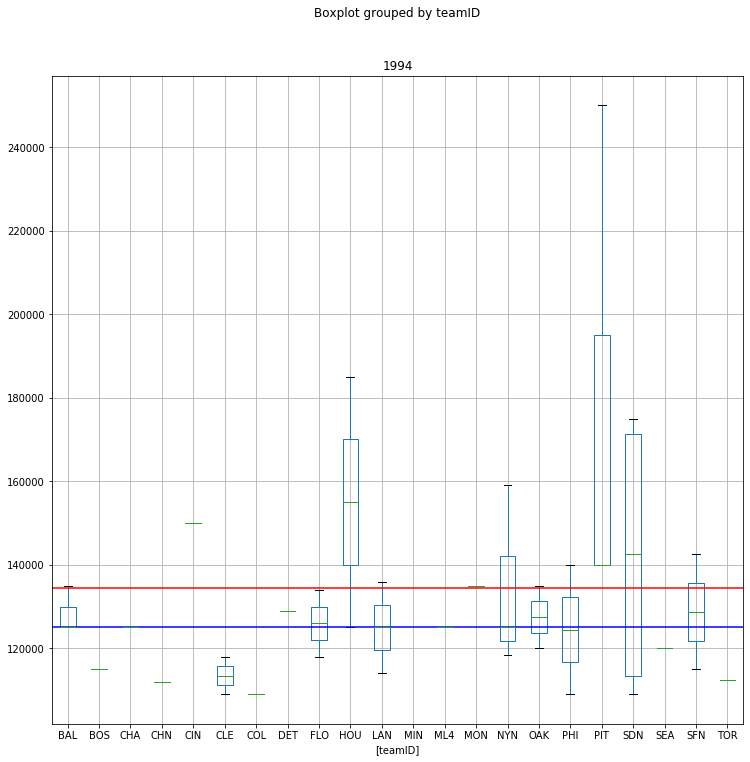

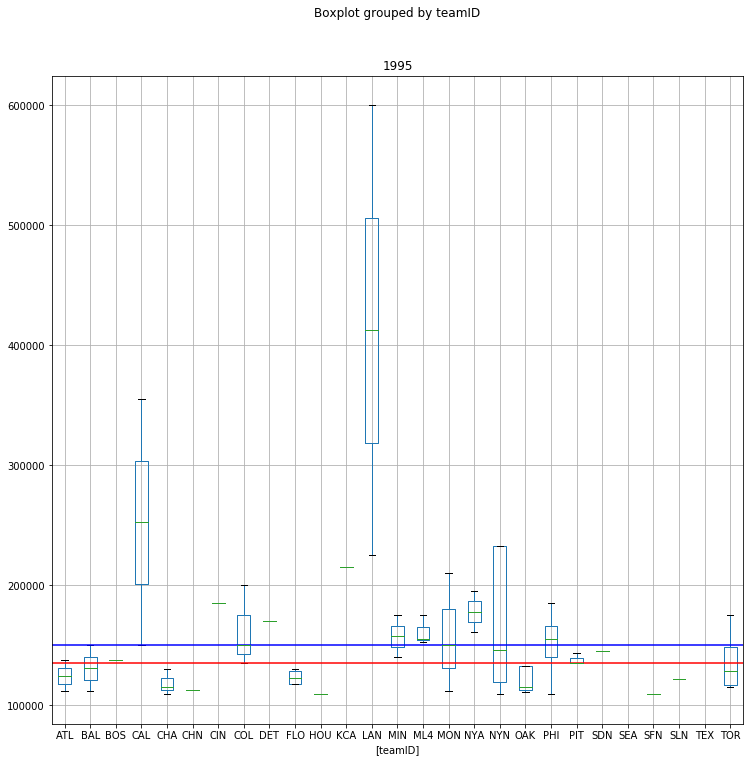

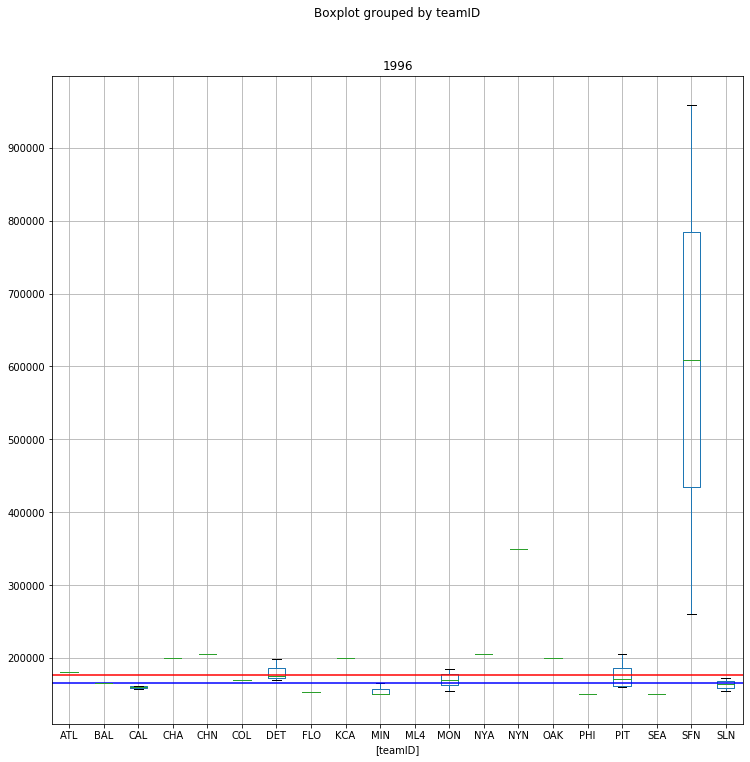

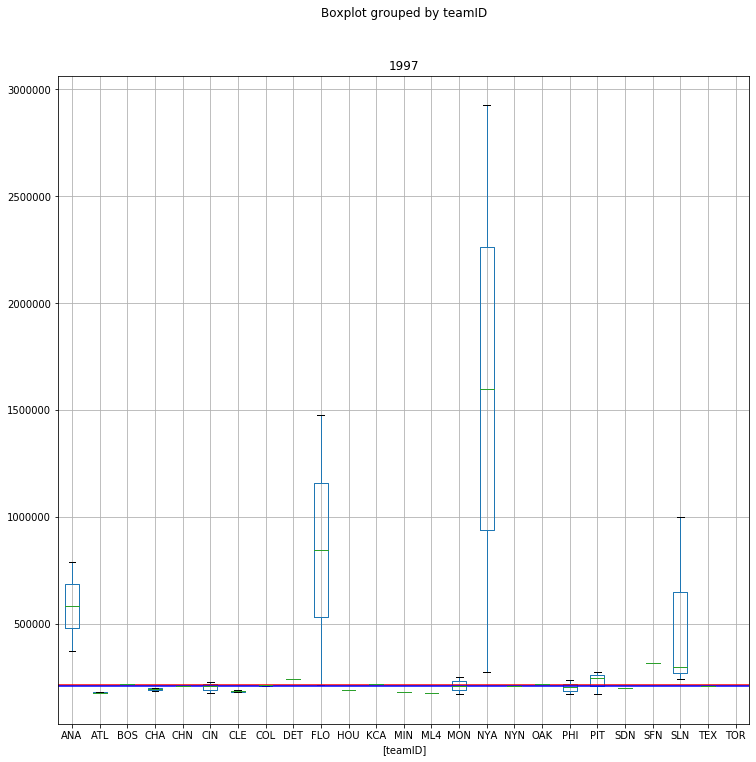

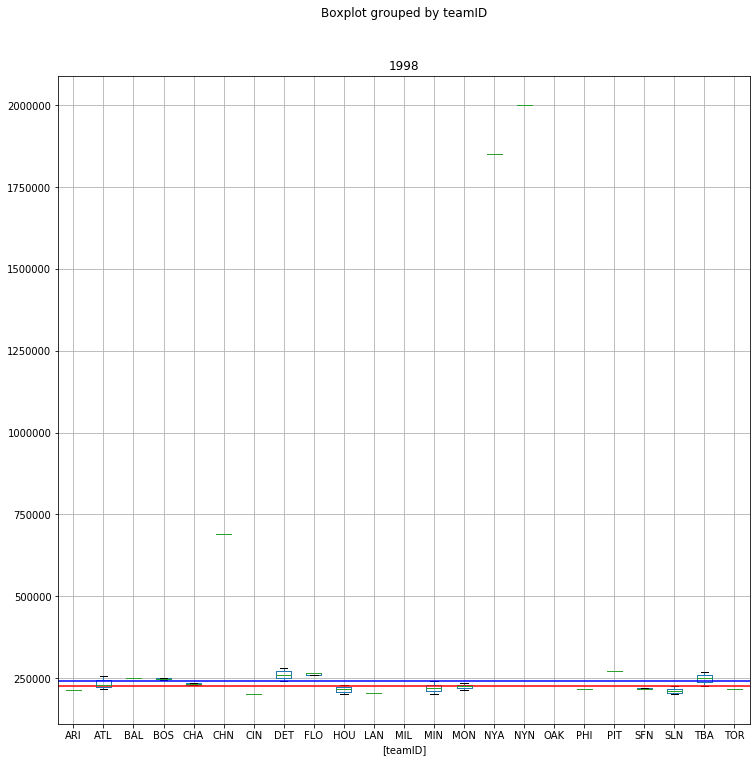

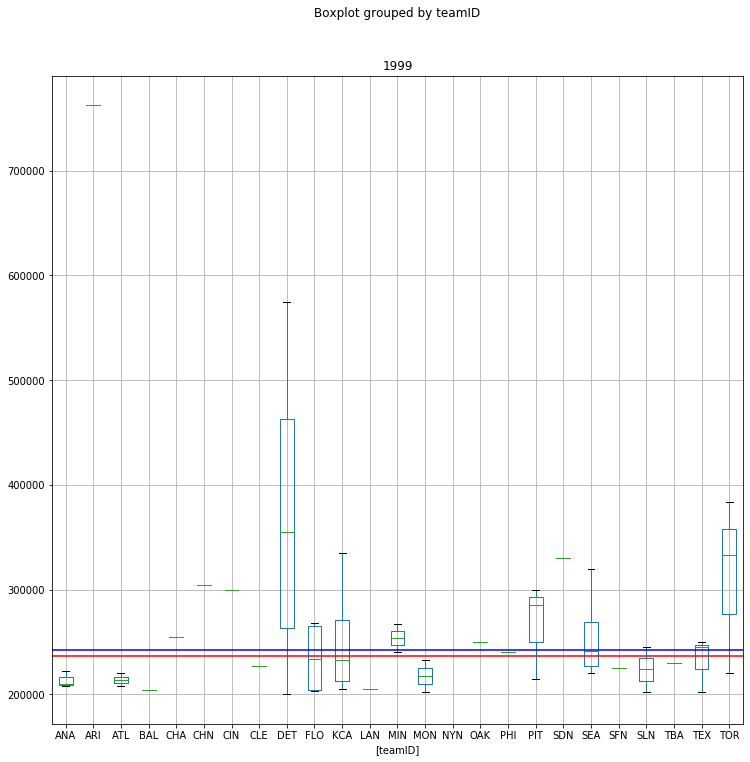

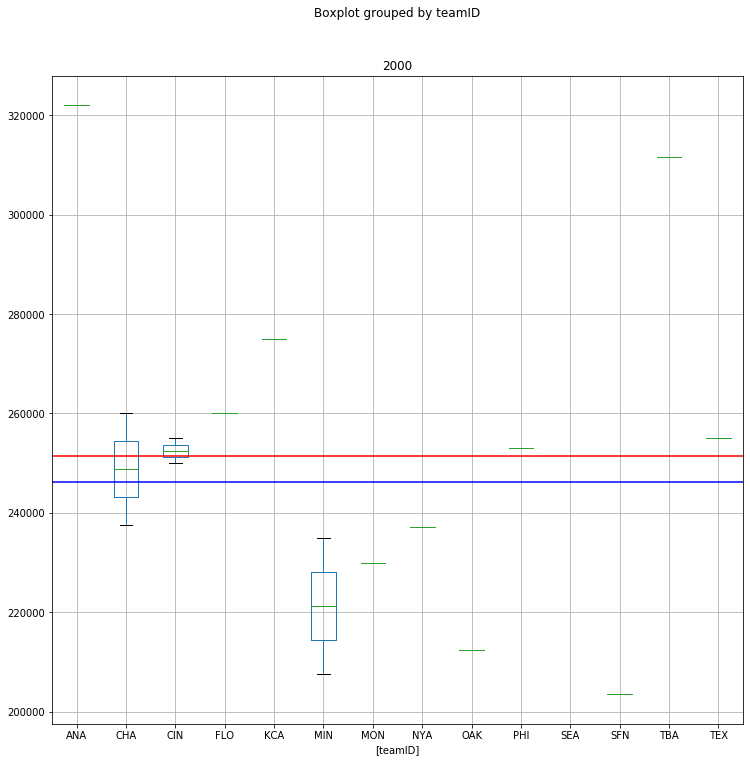

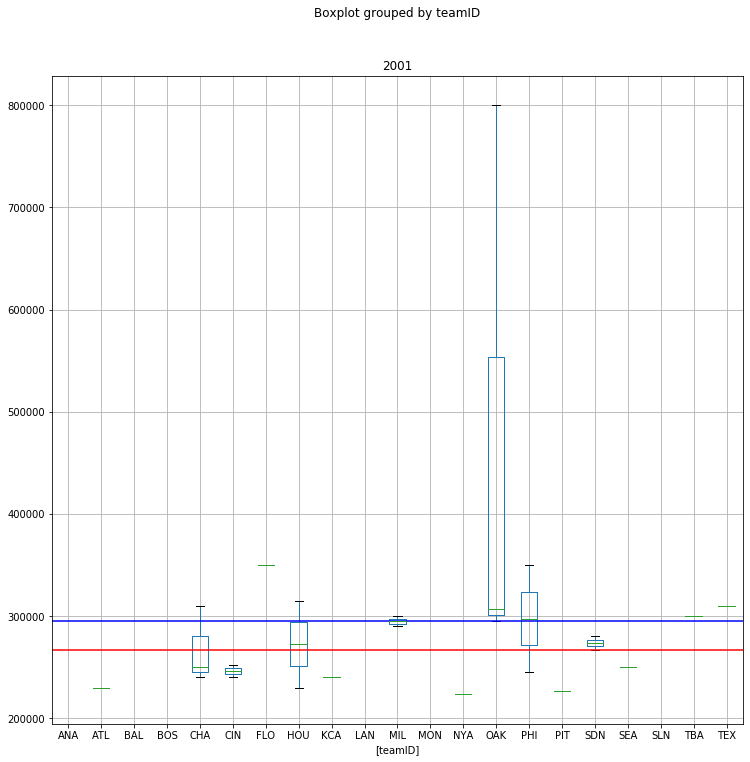

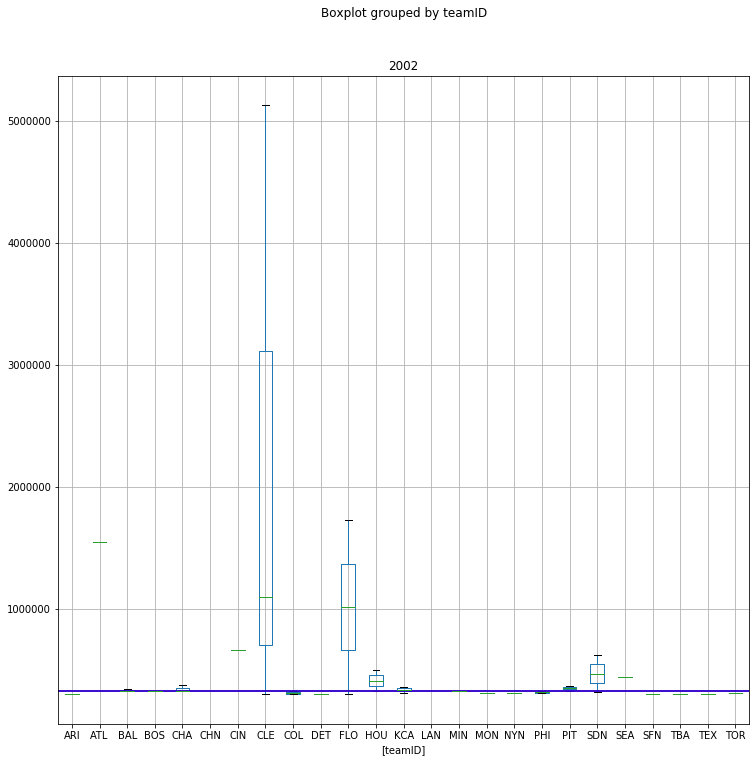

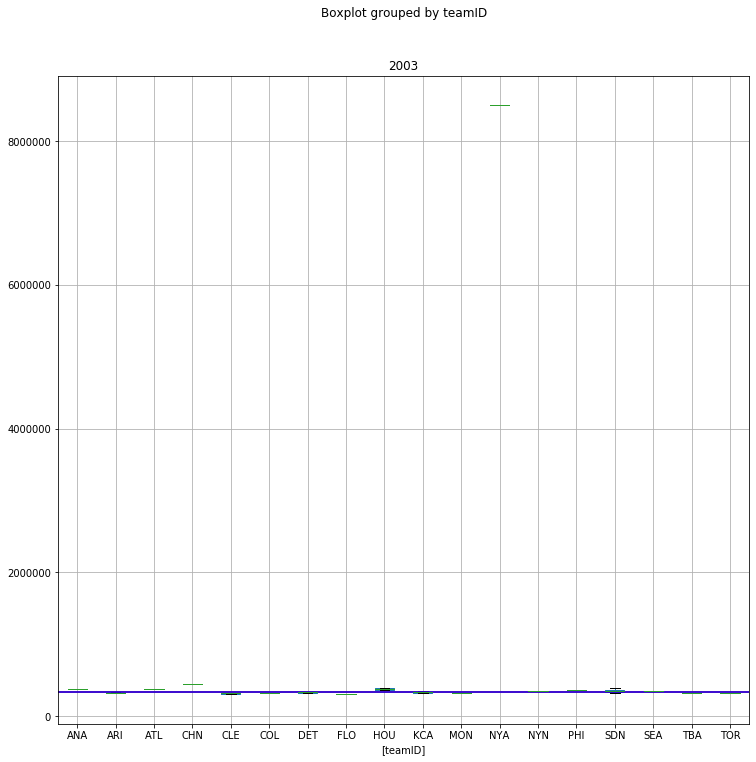

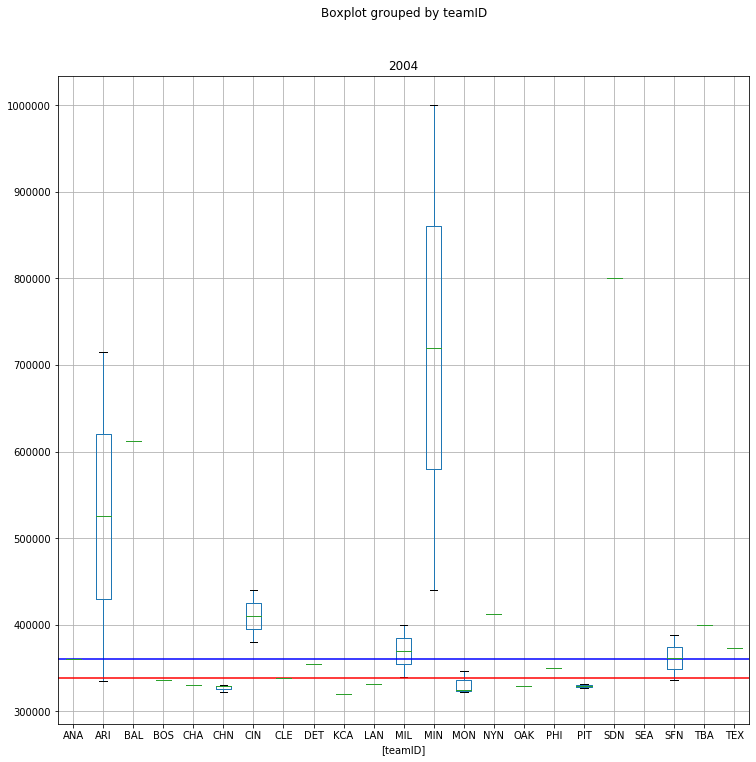

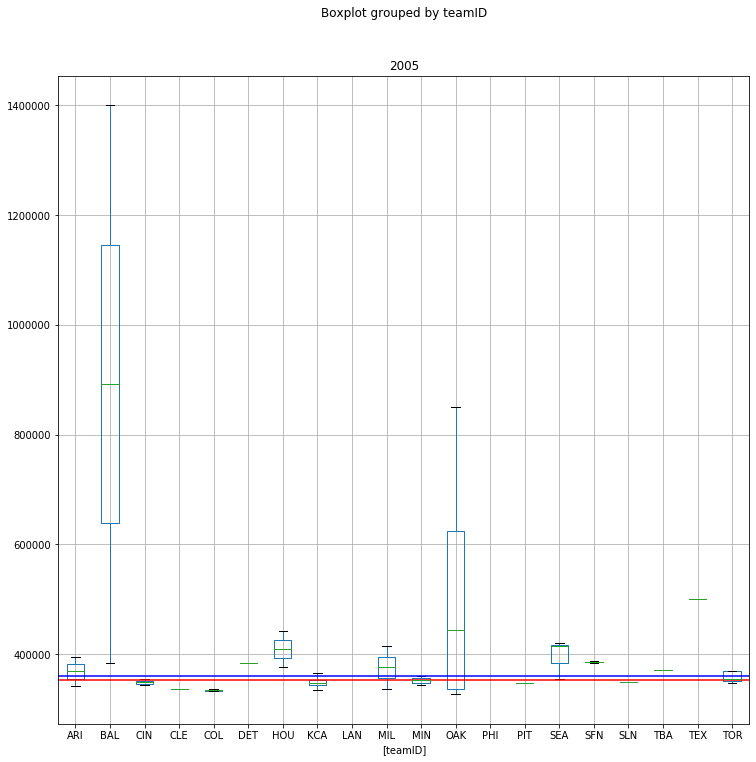

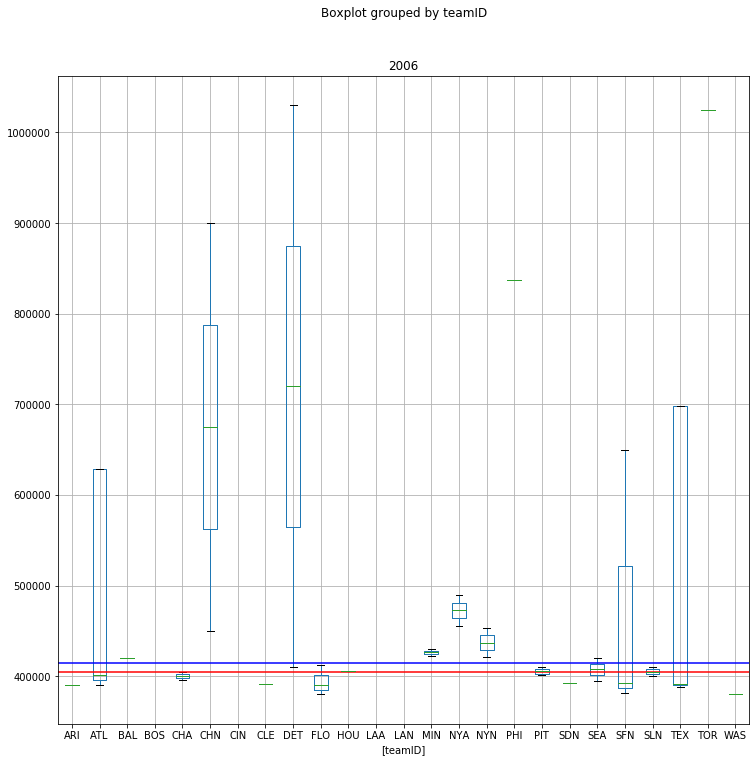

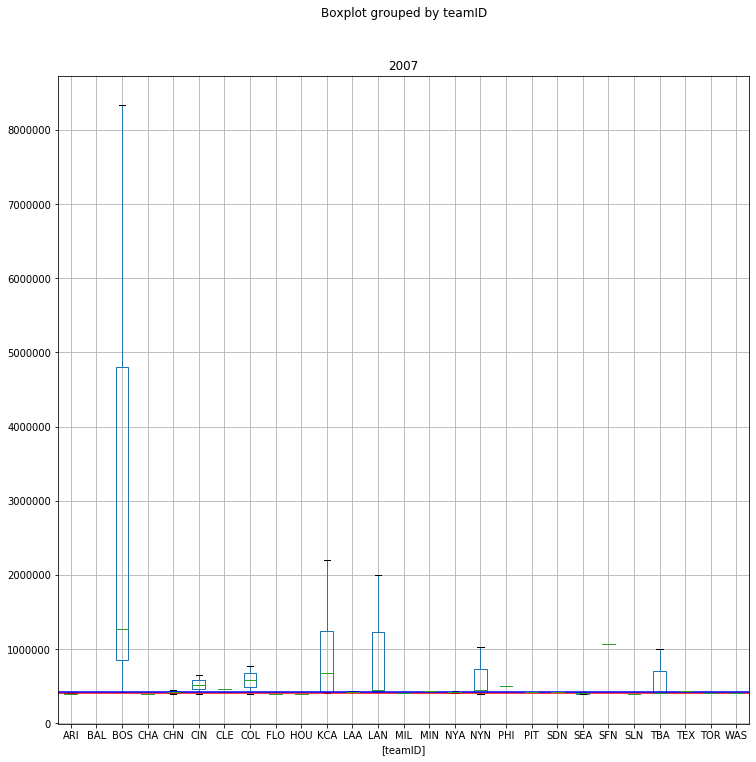

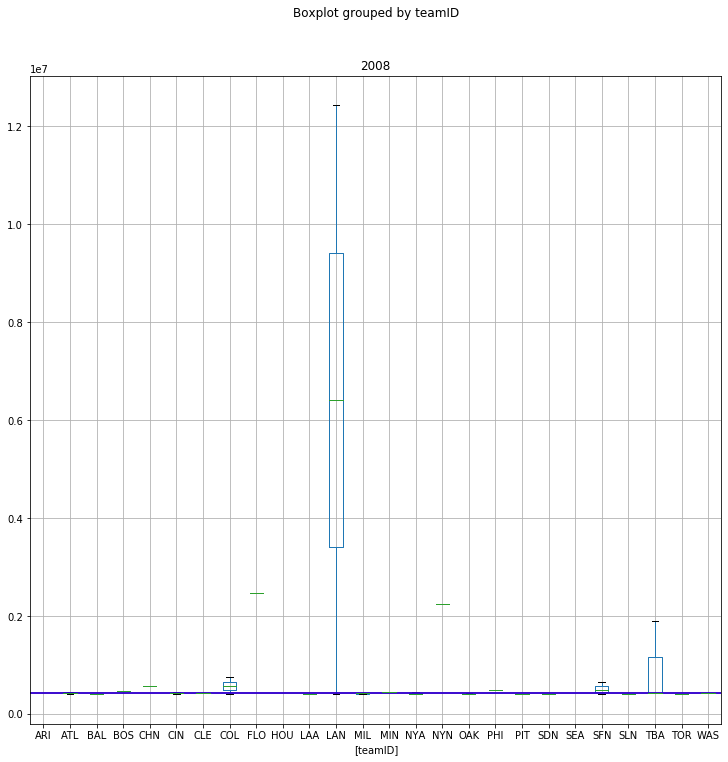

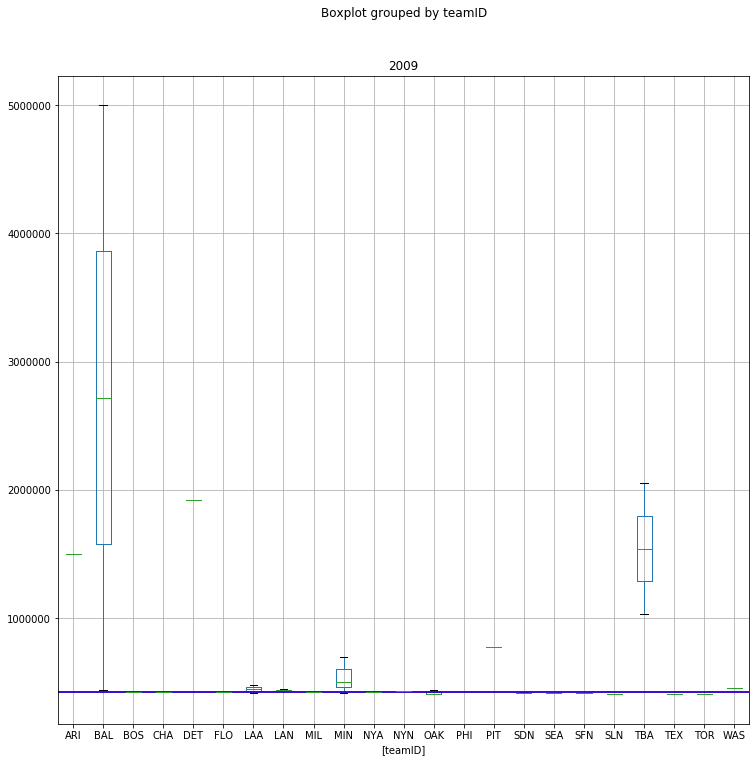

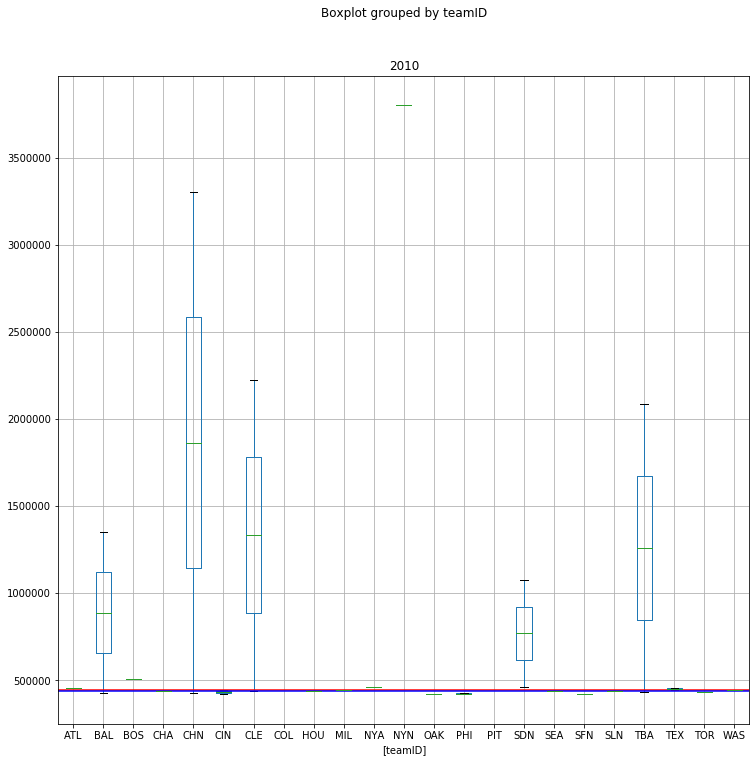

""


In [218]:
def TeamDiff(dfx):
    dfx.boxplot(column=['firstsalary'], by = ['teamID'], showfliers = False, figsize=(12,12))
    plt.title(str(dfx['yearID'].iloc[0]))
    plt.axhline(dfx['NL_startsalary_by_year'].iloc[0], color= 'r')
    plt.axhline(dfx['AL_startsalary_by_year'].iloc[0], color= 'b')
    plt.show()
df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)].groupby(['yearID']).apply(TeamDiff)
#.boxplot(column=['firstsalary'], by = ['teamID'], showfliers = False, figsize=(60,60))

In [219]:
#分析team
def TeamDiffSum(dfx):
    tmp = dfx['{0}_startsalary_by_year'.format(dfx['lgID'].iloc[0])]
    return ((dfx['firstsalary']-tmp)/tmp).sum()
def TeamDiffCubicSum(dfx):
    tmp = dfx['{0}_startsalary_by_year'.format(dfx['lgID'].iloc[0])]
    return (((dfx['firstsalary']-tmp)/tmp)**2).sum()

NewColumns = ['Team_Sum','Team_CubicSum']
for t in NewColumns: df[t] = df['teamID'].copy()
    
#df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)].groupby(['teamID']).apply(TeamDiffSum)
df['Team_Sum']      = df['Team_Sum']     .map(df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)].groupby(['teamID']).apply(TeamDiffSum))
df['Team_CubicSum'] = df['Team_CubicSum'].map(df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)].groupby(['teamID']).apply(TeamDiffCubicSum))
df.head()

,id,playerID,yearID,stint,teamID,lgID,W,L,G,GS,...,salary_next_year,years,firstsalary,firstyear,salary_the_year,totalyears,NL_startsalary_by_year,AL_startsalary_by_year,Team_Sum,Team_CubicSum
0,0,nelsoge01,1986,1,CHA,AL,6,6,54,1,...,365000.0,4.0,240000.0,1985.0,240000.0,7.0,117518.5,140750.0,-0.653918,1.598084
1,1,moyerja01,1997,1,SEA,AL,17,5,30,30,...,2000000.0,15.0,70000.0,1986.0,NaN,24.0,212500.0,208000.0,4.913768,6.322251
2,2,thompbr01,2008,1,SLN,NL,6,3,26,6,...,650000.0,0.0,400000.0,2006.0,414000.0,3.0,426000.0,420000.0,3.038064,15.460188
3,3,powerte01,1986,1,CIN,NL,10,6,56,10,...,500000.0,5.0,500000.0,1985.0,500000.0,8.0,117518.5,140750.0,4.310306,5.796661
4,4,osunaan01,2003,1,NYA,AL,2,5,48,0,...,750000.0,9.0,NaN,1995.0,2400000.0,10.0,330000.0,330000.0,61.016180,1074.742629


In [258]:
#對team做 dummy
df = pd.get_dummies(df, columns = ["teamID", "lgID"])
df.columns
df.columns[df.dtypes == 'object']

Index(['playerID'], dtype='object')

minvalue= -0.5160075657697318
158
min= 0.0
max= 1.9597799230726503


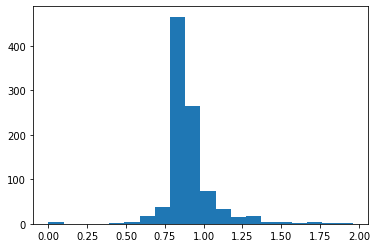

1110


In [350]:

df['start_salary_ratio'] = (df['salary_next_year'] - df['NL_startsalary_by_year']/2 - df['AL_startsalary_by_year']/2)/(df['NL_startsalary_by_year']/2 + df['AL_startsalary_by_year']/2)
minvalue = df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)]['start_salary_ratio'].min()
print("minvalue=",minvalue)
df['start_salary_ratio'] = (df['start_salary_ratio']-minvalue)**0.2

a = df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)]['start_salary_ratio']
print(a.isna().sum())
a = a[a.notna()]
print('min=',np.min(a.values))
print('max=',np.max(a.values))

plt.hist(a.values, bins= 20)
#plt.hist((a.values-np.min(a.values))**0.2, bins= 20)
plt.show()

a = df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)]
print(len(a))

In [260]:
df.head()
print(df.shape)
print("起薪判定 須把參數'id', 'playerID', 'firstsalary', 'salary_next_year', 'totalyears', 'salary_the_year' 去除")
print("起薪判定 並以'start_salary_ratio' 作為target")
df.columns

(7393, 73)
起薪判定 須把參數'id', 'playerID', 'firstsalary', 'salary_next_year', 'totalyears', 'salary_the_year' 去除
起薪判定 並以'start_salary_ratio' 作為target


Index(['id', 'playerID', 'yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO',
       'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB',
       'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'salary_next_year', 'years',
       'firstsalary', 'firstyear', 'salary_the_year', 'totalyears',
       'NL_startsalary_by_year', 'AL_startsalary_by_year', 'Team_Sum',
       'Team_CubicSum', 'start_salary_ratio', 'teamID_ANA', 'teamID_ARI',
       'teamID_ATL', 'teamID_BAL', 'teamID_BOS', 'teamID_CAL', 'teamID_CHA',
       'teamID_CHN', 'teamID_CIN', 'teamID_CLE', 'teamID_COL', 'teamID_DET',
       'teamID_FLO', 'teamID_HOU', 'teamID_KCA', 'teamID_LAA', 'teamID_LAN',
       'teamID_MIL', 'teamID_MIN', 'teamID_ML4', 'teamID_MON', 'teamID_NYA',
       'teamID_NYN', 'teamID_OAK', 'teamID_PHI', 'teamID_PIT', 'teamID_SDN',
       'teamID_SEA', 'teamID_SFN', 'teamID_SLN', 'teamID_TBA', 'teamID_TEX',
       'teamID_TOR', 'teamID_WAS', 'lgID_AL', 'lgID_NL'],
      dtype='object')

In [367]:
from sklearn.linear_model import LogisticRegression


train_data = df[(df['firstyear']==df['yearID']) & (df['yearID']!=1985)].drop(columns = ['id', 'playerID', 'totalyears', 'salary_the_year', 'firstsalary', 'salary_next_year'])
target     = 'start_salary_ratio'

train_data[['NL_startsalary_by_year', 'AL_startsalary_by_year']] = np.log1p(train_data[['NL_startsalary_by_year', 'AL_startsalary_by_year']])
test_data    = train_data[train_data[target].isna()].drop(columns = [target])
train_data_x = train_data[train_data[target].notna()].drop(columns = [target])
train_data_y = train_data[train_data[target].notna()][target]

other_params = {'learning_rate': 0.05, 'n_estimators': 1000, 'max_depth': 100, 'min_child_weight': 1, 'seed': 0,
'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = XGBRegressor(**other_params)

#model = RandomForestRegressor(n_estimators =10)
#model = LogisticRegression()
train_X, test_X, train_Y, test_Y = train_test_split(train_data_x, train_data_y, test_size=0.6)

model.fit(train_X, train_Y)
predict_train_y= model.predict(train_X)

score_train = metrics.r2_score(train_Y.values, predict_train_y)
print('train score=', score_train)
predict_test_y= model.predict(test_X)
score_test = metrics.r2_score(test_Y.values, predict_test_y)
print('test score =', score_test)

#test_data.shape

[17:05:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train score= 0.9999908573937767
test score = 0.06265687752796323


train= 0.00032614962420314135
test = 0.08958157185447105
1.2821805
0.576311


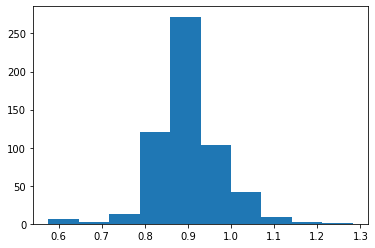

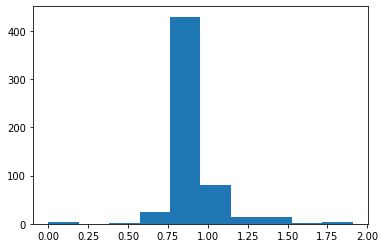

In [376]:
print("train=",metrics.mean_absolute_error(train_Y.values, predict_train_y))
print("test =",metrics.mean_absolute_error(test_Y.values, predict_test_y))

print(np.max(predict_test_y))
print(np.min(predict_test_y))
plt.hist(predict_test_y)
plt.show()

plt.hist(test_Y)
plt.show()

In [385]:
a = pd.concat([pd.Series(test_Y.values),pd.Series(predict_test_y)],axis=1)
a['diff'] = abs(a[0]-a[1])
a[a['diff']>0.5]

,0,1,diff
111,1.129599,0.606075,0.523525
138,0.000000,0.861219,0.861219
141,1.488953,0.869359,0.619594
166,0.000000,0.590684,0.590684
167,1.455466,0.930177,0.525289
247,1.337000,0.833515,0.503484
333,1.907802,0.898823,1.008979
387,1.681134,0.844274,0.836860
388,1.725260,1.023796,0.701464
461,1.290667,0.606673,0.683993


In [303]:
a = train_data['start_salary_ratio'].values

print(np.min((a-np.min(a))))
#plt.hist((a-np.min(a))**0.15)
df['start_salary_ratio'].isna().sum()
#len(df[(df['start_salary_ratio']<10) | (df['start_salary_ratio'].isna())])
len(df[(df['start_salary_ratio']<10)])

nan


4777

1.3810103
0.691298


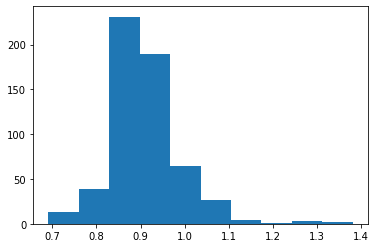

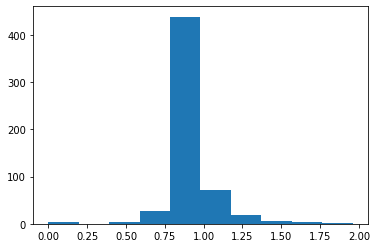

In [365]:
print(np.max(predict_test_y))
print(np.min(predict_test_y))
plt.hist(predict_test_y)
plt.show()

plt.hist(test_Y)
plt.show()

In [265]:
print(train_X.columns)
train_X['start_salary_ratio']

Index(['yearID', 'stint', 'W', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts',
       'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp', 'ERA', 'IBB', 'WP', 'HBP', 'BK',
       'BFP', 'GF', 'R', 'years', 'firstyear', 'NL_startsalary_by_year',
       'AL_startsalary_by_year', 'Team_Sum', 'Team_CubicSum',
       'start_salary_ratio', 'teamID_ANA', 'teamID_ARI', 'teamID_ATL',
       'teamID_BAL', 'teamID_BOS', 'teamID_CAL', 'teamID_CHA', 'teamID_CHN',
       'teamID_CIN', 'teamID_CLE', 'teamID_COL', 'teamID_DET', 'teamID_FLO',
       'teamID_HOU', 'teamID_KCA', 'teamID_LAA', 'teamID_LAN', 'teamID_MIL',
       'teamID_MIN', 'teamID_ML4', 'teamID_MON', 'teamID_NYA', 'teamID_NYN',
       'teamID_OAK', 'teamID_PHI', 'teamID_PIT', 'teamID_SDN', 'teamID_SEA',
       'teamID_SFN', 'teamID_SLN', 'teamID_TBA', 'teamID_TEX', 'teamID_TOR',
       'teamID_WAS', 'lgID_AL', 'lgID_NL'],
      dtype='object')


2137   -0.046915
653    -0.252747
4601   -0.035088
5303   -0.178082
1752   -0.086022
          ...   
5801    0.001927
4502    0.052632
5416    0.260745
1874   -0.037249
2953    3.735306
Name: start_salary_ratio, Length: 380, dtype: float64

In [177]:
test_1 = test_X.copy()
test_1['pre_salary']=np.exp(predict_test_y)-1

test_2 = train_X.copy()
test_2['pre_salary']=np.exp(predict_train_y)-1

test_3 = train_data_x.copy()
test_3['pre_salary']=np.exp(train_data_y)-1

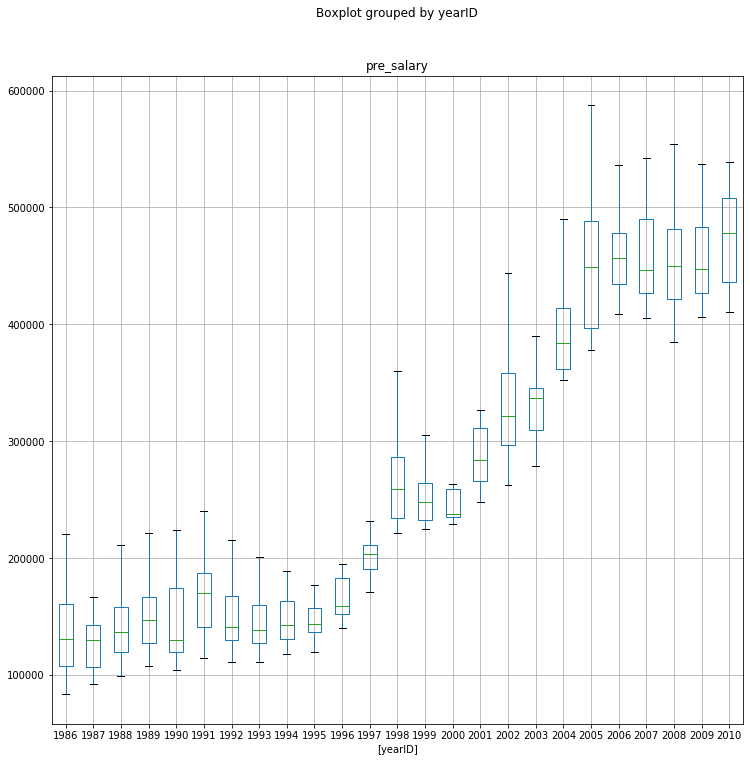

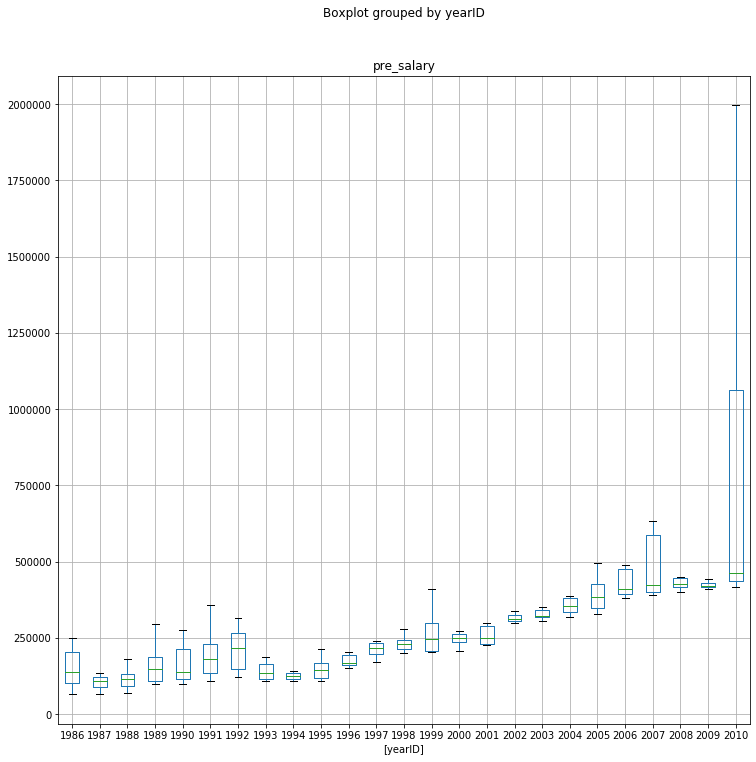

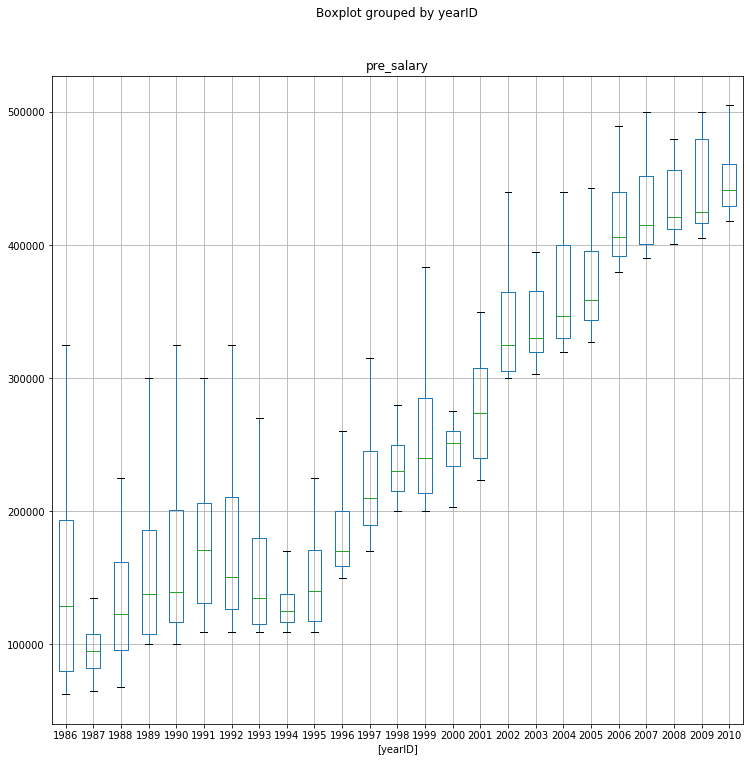

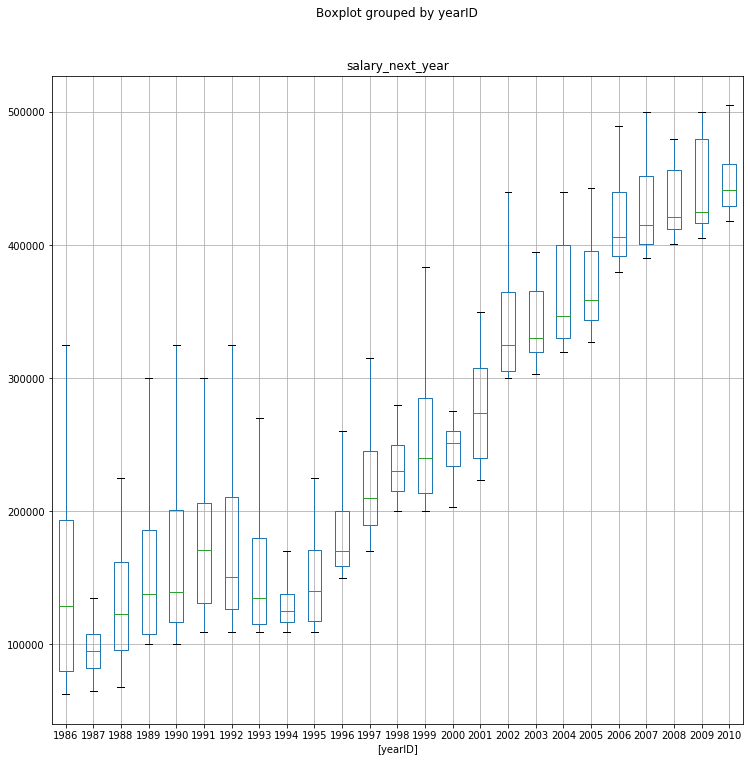

In [178]:
test_1.boxplot(column=['pre_salary'], by = ['yearID'], showfliers = False, figsize=(12,12))
test_2.boxplot(column=['pre_salary'], by = ['yearID'], showfliers = False, figsize=(12,12))
test_3.boxplot(column=['pre_salary'], by = ['yearID'], showfliers = False, figsize=(12,12))
train_data.boxplot(column=['salary_next_year'], by = ['yearID'], showfliers = False, figsize=(12,12))

In [72]:
df[df[['NL_startsalary_by_year', 'AL_startsalary_by_year']].isna()]

,id,playerID,yearID,stint,W,L,G,GS,CG,SHO,...,teamID_SDN,teamID_SEA,teamID_SFN,teamID_SLN,teamID_TBA,teamID_TEX,teamID_TOR,teamID_WAS,lgID_AL,lgID_NL
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
'''
4973	ueharko01	2009	5000000.0	426750.0	10.740534
2278	irabuhi01	1997	2925000.0	212500.0	12.912010
4832	baezda01	2002	5125000.0	325000.0	14.769231
4659	howest01	1992	2500000.0	152000.0	15.556291
46	matsuda01	2007	8333333.0	405250.0	19.074274
4658	contrjo01	2003	8500000.0	330000.0	24.757576
4429	kurodhi01	2008	12433333.0	426000.0	28.393222
'''

mask = (df['playerID']=='matsuda01').values
df.iloc[mask,:].sort_values(by='yearID')[['teamID', 'lgID', 'yearID','salary_next_year']]

,teamID,lgID,yearID,salary_next_year
46,BOS,AL,2007,8333333.0
209,BOS,AL,2008,8333333.0
5477,BOS,AL,2009,8333333.0
562,BOS,AL,2010,10333333.0
3943,BOS,AL,2011,10333333.0


In [235]:
df[(df['teamID']=="BOS") & (df['lgID']=="AL")].sort_values(by=['playerID','yearID'])[['playerID', 'teamID', 'lgID', 'yearID','salary_next_year']].to_csv('Result.csv')

In [44]:
(df['playerID']=='nelsoge01').sum()

7

In [167]:
x=50
np.exp(np.log1p(x))-1


50.0

In [ ]:
def top(df,n=5,column='yearID'):
    return df.sort_values(by=column)[-n:]

df.groupby('playerID').apply(top)